# Figure 1

This notebook recreates Figure 1 from the original publication, presenting an overview of the LERM analysis technique.

In [1]:
import pyleoclim as pyleo
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import ammonyte as amt
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

Setting font sizes for the figures

In [3]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Using [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to load the data we'll be using for this example.

In [4]:
series = pyleo.utils.load_dataset('LR04').slice((0,2400))

time = series.time

series = series.interp(time_axis=np.arange(int(min(time)),int(max(time))))

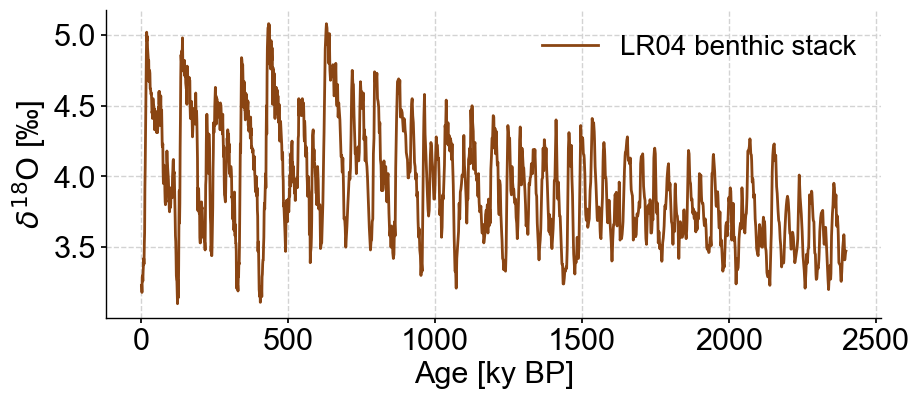

In [5]:
fig, ax = series.plot(color='#8A4513')

Embedding with an embedding dimension `m` of 12 and tau selected according to the first minimum of mutual information, then calculating the recurrence plot. Targeting a recurrence density of 5% (this is the default).

In [6]:
td = amt.TimeEmbeddedSeries(series,m=12)
rm = td.find_epsilon(eps=1)['Output']
print(f'Tau is : {td.tau}')

Initial density is 0.0544
Initial density is within the tolerance window!
Tau is : 17


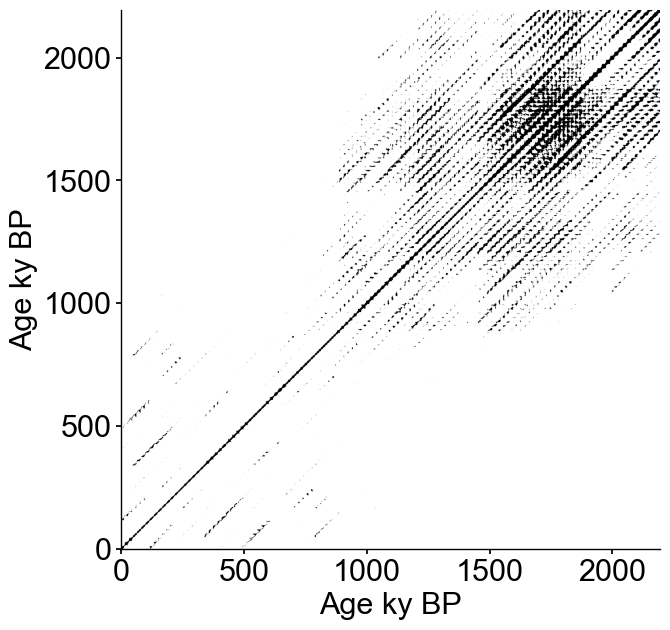

In [7]:
fig,ax = rm.plot(figsize=(7,7))

xticks = ax.get_xticks()
xlim = ax.get_xlim()
ax.set_yticks(xticks)
ax.set_ylim(xlim)
ax.set_title(None)
ax.grid(False)

Carrying out the Laplacian eigenmapping + Fisher information steps using a window size of 50 indices and a window increment of 5.

In [8]:
lp = rm.laplacian_eigenmaps(w_size=50,w_incre=5)

In [9]:
def plot_eigenmaps(self,groups,axes,figsize=(12,12),palette='colorblind',ax=None,title=None):
    '''Function to display eigenmaps

    Only works when the RQARes has been created via the laplacian eigenmaps function

    Parameters
    ----------

    groups : list,tuple; (start,stop)
        List of lists or tuples containing start stop time indices for coloring. Should be ordered in time.

    axes : list,tuple
        Axes of the eigenvectors. Should be list or tuple of length 2.

    figsize : list,tuple
        Size of the figure

    palette : str, list
        Color map to use for color coding according to time. Can either be the name of a color map or a list of colors
        
    ax : matplotlib.axes.Axes
        Ax object to plot on.

    Returns
    -------

    fig : matplotlib.figure
        The figure object from matplotlib.
        See `matplotlib.pyplot.figure <https://matplotlib.org/stable/api/figure_api.html>`_ for details.

    ax : matplotlib.axis 
        The axis object from matplotlib. 
        See `matplotlib.axes <https://matplotlib.org/stable/api/axes_api.html>`_ for details.

    '''

    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    
    data_dict = {
        'eig1' : [],
        'eig2' : [],
        'Group' : []
    }
    eigvec = self.eigenmap

    for idx,group in enumerate(groups):

        if not isinstance(group,(list,tuple)) or len(group) != 2:
            raise ValueError(f'Group [{idx}] format is not recognized. Please use [(start,stop),(start,stop),etc.] format for groups.')

        start = group[0]
        stop = group[1]

        if start > max(self.time) or start < min(self.time):
            print('Start value exceed time bounds of RQARes object, ')
            start = max(self.time)

        if stop > max(self.time) or stop < min(self.time):
            raise ValueError(f'Stop time [{stop}] from group [{idx}] is not within the time bounds of your RQARes object.')

        start_index = np.where(self.series.time==start)[0][0]
        stop_index = np.where(self.series.time==stop)[0][0]

        eig1 = eigvec[:,axes[0]][start_index:stop_index]
        eig2 = eigvec[:,axes[1]][start_index:stop_index]
        labels = [f'{group}' for i in range(len(eig1))]
        data_dict['eig1'].extend(eig1)
        data_dict['eig2'].extend(eig2)
        data_dict['Group'].extend(labels)
        
    data = pd.DataFrame(data_dict)
    sns.scatterplot(data=data,x='eig1',y='eig2',hue='Group',palette='colorblind',edgecolor=None)

    if title is None:
        title = f'Eigenmaps for {self.label}'

    ax.set_title(title)
    ax.set_xlabel(f'$\Phi_{axes[0]}$',labelpad=10)
    ax.set_ylabel(f'$\Phi_{axes[1]}$',labelpad=10)
    ax.ticklabel_format(axis='x', scilimits=[0, 0])
    ax.ticklabel_format(axis='y', scilimits=[0, 0])
    
    ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')

    if 'fig' in locals():
        return fig, ax
    else:
        return ax


def plot_eigenmaps_FI(self,groups,axes,palette='colorblind',figsize=(18,12),
                      FI_axis_lims=None,scale=(1,1,1),title=None):
    '''Function to display eigenmaps as a function of fisher information

    Only works when the RQARes has been created via the laplacian eigenmaps function

    Parameters
    ----------

    groups : list,tuple; (start,stop)
        List of lists or tuples containing start stop time indices for block smoothing.

    axes : list,tuple
        Axes of the eigenvectors to plot against Fisher Information. Should be list or tuple of length 2.

    palette : str
        Color map to use for color coding according to time

    figsize : list,tuple
        Size of the figure

    FI_axis_lims : list,tuple
        Boundaries for the fisher information axis

    Returns
    -------

    fig : matplotlib.figure
        The figure object from matplotlib.
        See `matplotlib.pyplot.figure <https://matplotlib.org/stable/api/figure_api.html>`_ for details.

    ax : matplotlib.axis 
        The axis object from matplotlib. 
        See `matplotlib.axes <https://matplotlib.org/stable/api/axes_api.html>`_ for details.

    '''

    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
        
    cmap = sns.color_palette(palette,len(groups))
    
    data_dict = {
        'eig1' : [],
        'eig2' : [],
        'FI' : [],
        'c' : []
    }
    
    eigvec = self.eigenmap

    for idx,group in enumerate(groups):

        if not isinstance(group,(list,tuple)) or len(group) != 2:
            raise ValueError(f'Group [{idx}] format is not recognized. Please use [(start,stop),(start,stop),etc.] format for groups.')

        start = group[0]
        stop = group[1]

        if start > max(self.time) or start < min(self.time):
            print('Start value exceed time bounds of RQARes object, ')
            start = max(self.time)

        if stop > max(self.time) or stop < min(self.time):
            raise ValueError(f'Stop time [{stop}] from group [{idx}] is not within the time bounds of your RQARes object.')

        start_index = np.where(self.series.time==start)[0][0]
        stop_index = np.where(self.series.time==stop)[0][0]
        
        eig1 = eigvec[:,axes[0]][start_index:stop_index]
        eig2 = eigvec[:,axes[1]][start_index:stop_index]
        labels = [cmap[idx] for i in range(len(eig1))]
        
        data_dict['eig1'].extend(eig1)
        data_dict['eig2'].extend(eig2)
        data_dict['c'].extend(labels)
        
        rqa_slice = self.slice(group)
        FI_block_value = np.mean(rqa_slice.value)
        FI = np.full(len(eig1), FI_block_value)
        data_dict['FI'].extend(FI)
        
    data = pd.DataFrame(data_dict)
    x = data['FI']
    y = data['eig1']
    z = data['eig2']
    c = data['c']

    if FI_axis_lims:
        ax.set_xlim(left=min(FI_axis_lims),right=max(FI_axis_lims))
    
    sc=ax.scatter(x,y,z,s=40, c=c, marker='o', alpha=1)

    ax.set_xlabel('FI',labelpad=20,loc='center')
    ax.set_ylabel(f'$\Phi_{axes[0]}$',labelpad=20,loc='center')
    ax.set_zlabel(f'$\Phi_{axes[1]}$',labelpad=20)
    ax.ticklabel_format(axis='x', scilimits=[0, 0])
    ax.ticklabel_format(axis='y', scilimits=[0, 0])
    ax.ticklabel_format(axis='z', scilimits=[0, 0])
    ax.tick_params(axis='both', which='major', pad=10)
    ax.set_title(title)

    scale_x,scale_y,scale_z = scale
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1]))
    
    ax.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

    if 'fig' in locals():
        return fig, ax
    else:
        return ax

Text(0.5, 1.0, '')

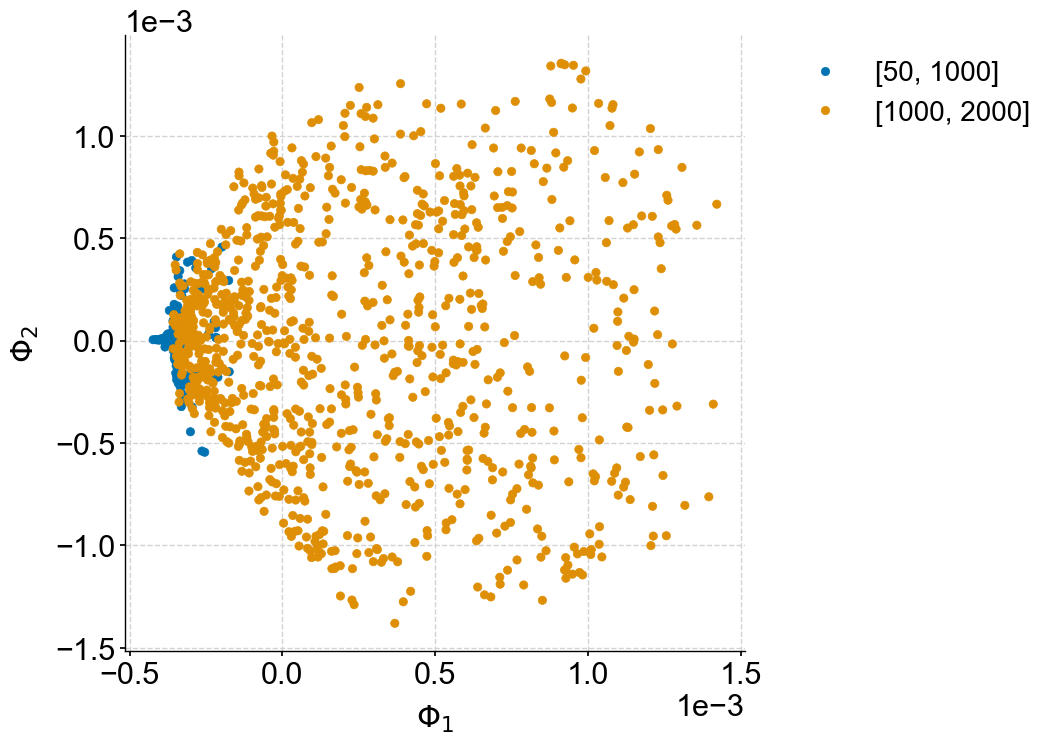

In [10]:
fig,ax = plot_eigenmaps(lp,groups=[[50,1000],[1000,2000]],axes=[1,2],figsize=(8,8))
ax.set_title(None)

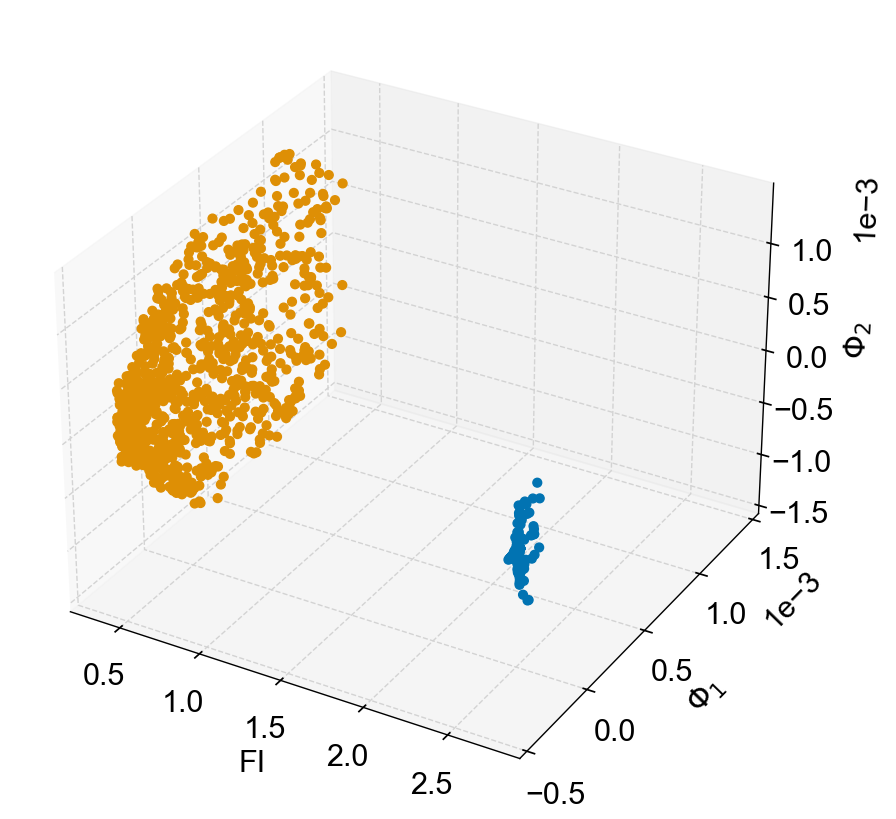

In [11]:
fig,ax=plot_eigenmaps_FI(lp,groups=[[50,1000],[1000,2000]],axes=[1,2],figsize=(8,8))

In [12]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

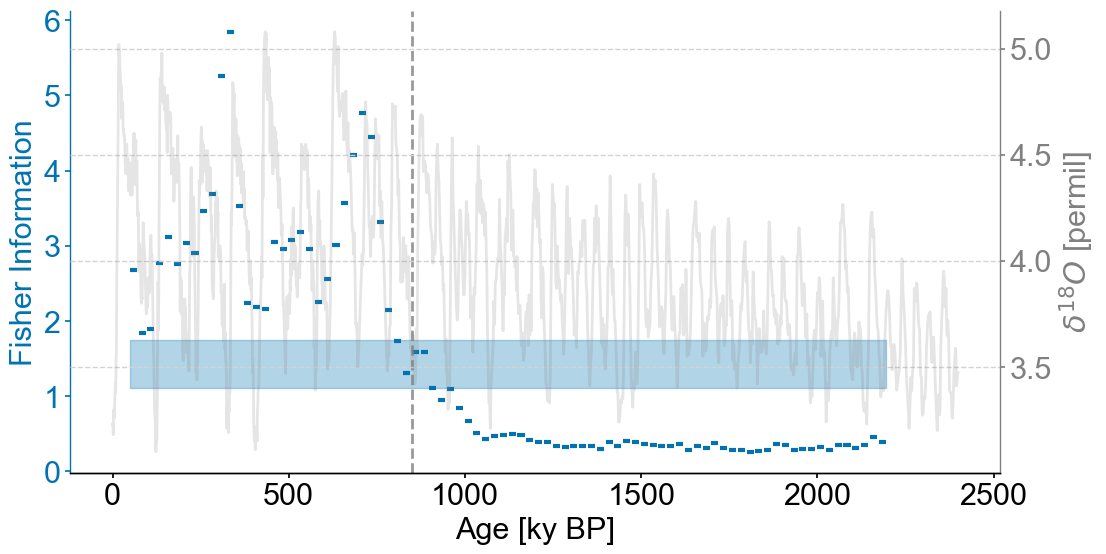

In [13]:
color_list = sns.color_palette('colorblind')

lp_smooth = lp.smooth(block_size=5) #Binning the Fisher information into blocks with a given number of indices
upper, lower = amt.utils.sampling.confidence_interval(series=lp,upper=95,lower=5,w=50,n_samples=10000) #Finding upper and lower bounds for our transition interval
transitions=detect_transitions(lp_smooth,transition_interval=(upper,lower))

fig,ax = lp.confidence_smooth_plot(
    background_series = series,
    block_size=5,
    color=color_list[0],
    figsize=(12,6),
    title='',
    legend=True,
    lgd_kwargs={'loc':'upper left'},
#     hline_kwargs={'label':None},
    background_kwargs={'ylabel':'$\delta^{18}O$ [permil]','legend':False})

ax.legend().set_visible(False)
ax.axvline(transitions[0],linestyle='dashed',color='grey',alpha=.8)